# **The Problem: Automatic Apparent Age Estimation**
Author: Àlex Pujol and Gerard Castro

---



# **Objectives**:

- Play with different machine learning concepts incrementaly.

- Define new strategies to **improve accuracy** performance (overall and per attribute) **while minimizing the different bias scores**.

- Based on your experiments, be able to provide a strong analysis and discussion of the results when delivering your report.

- **IMPORTANT:** as you will see, the problem is basicaly solved in this starting-kit. However, **we expect you to to beyond the starting-kit**. We expect you to play with different hyperparameters, training strategies, different backbones, etc. Avoid making minor changes on the provided code as your final solution. You won't be evaluated based on the accuracy your model provide, but based on your creativity and the way you define the experiments, report and discuss the results (using the report document template - more information will be provided on Virtual Campus).
- **NOTE:** the preliminary discussion provided in this Colab file is based on the results obtained on the **validation set**. You should be able to train different models and evaluate different strategies using the training and validation set. When you are done (that is, when you are satisfied with your results), you can obtain **the final results on the TEST** set using the competition webpage we created for this course. That is, you should not have access to the test labels. We consider this a good excercise where we try to simulate a real situation where people don't have access to the test labels (also usefull to avoid overfitting on the test data). The details about the competition can be found on Virtual Campus.


---
---
########### **Bias Mitigation (strategy 1.1: custom strategy)** ##############
---
---
---

## Improved Data Augmentation process: compound categories

We have seen there are different groups in the metadata: 2 genders, 3 ethnicicies & 4 facial expressions. Along with the 4 age groups, we could classify each sample in 1 of the total possible $2\times 3\times 4\times 4 = 96$ categories. Let us find the histogram for each...

In [ ]:
!pip install tensorflow==2.8.2
!pip install opencv-python
!pip install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uni

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
from glob import glob
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple
import random
import cv2
from builtins import zip
from zipfile import ZipFile
import h5py
import tensorflow as tf

_OUTPUT_PATH: str = '/kaggle/working'
_INPUT_PATH: str = '/kaggle/input/cv-age-app-data'

# we also download the model in case we don't have it
if not os.path.isfile(f"{_OUTPUT_PATH}/best_model.h5"):
    !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
    # decompressing the data
    with ZipFile(f'{_OUTPUT_PATH}/best_model_st1.zip','r') as _zip:
        _zip.extractall()
    print('Model decompressed successfully')
    # removing the .zip file after extraction  to clean space
    !rm best_model_st1.zip

In [ ]:
# loading the train data (with labels)
X_train = np.load(f'{_INPUT_PATH}/data/data_train.npy')
Y_train = np.load(f'{_INPUT_PATH}/data/labels_train.npy')
M_train = np.load(f'{_INPUT_PATH}/data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load(f'{_INPUT_PATH}/data/data_valid.npy')
Y_valid = np.load(f'{_INPUT_PATH}/data/labels_valid.npy')
M_valid = np.load(f'{_INPUT_PATH}/data/meta_data_valid.npy')

# loading the test data (images only) to be used later in our challenge
X_test = np.load(f'{_INPUT_PATH}/data/data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train / 100
Y_valid = Y_valid / 100

### Custom functions

In [ ]:
####################################################################
# -------------------------------------------
DROP_OVERREPRESENTED_CATEGORIES: bool = False
_OUTPUT_PATH: str = '/kaggle/working/'
# -------------------------------------------


####################################################################
# MAIN FUNCTIONS
####################################################################

def advanced_da(_silent: bool = False) -> dict:
    comp_categories: np.ndarray = create_compound_categories(Y_train, M_train)
    comp_dict: dict = create_count_dictionary(comp_categories)
    variation_dict = define_sample_variation(comp_dict)
    augmented_arrays: dict = apply_data_augmentation(
        variation_dict, comp_categories, X_train, M_train, Y_train)

    if not _silent:
        da_comp_categories = list(augmented_arrays.values())[0]
        _show_distribution(
            [comp_categories, da_comp_categories], ['Before DA', 'After DA'])
        print(f"Before DA there were {comp_categories.shape[0]} samples. "
              f"After DA there are {da_comp_categories.shape[0]} samples.")
    return augmented_arrays


def apply_data_augmentation(
        variation_dict: dict, categories: np.ndarray,
        samples: np.ndarray, metadata: np.ndarray, labels: np.ndarray) \
        -> dict:
    arrays = {'categories': categories, 'samples': samples,
              'metadata': metadata, 'labels': labels}
    print("\n Applying data augmentation. PLEASE WAIT \n")
    for _category, _variation in variation_dict.items():
        if _variation < 0:  # then we have to drop samples
            _idx_drop = find_indices_to_drop(
                categories, _category, abs(_variation))
            for _k in arrays.keys():
                arrays[_k] = np.delete(arrays[_k], _idx_drop, axis=0)
        elif _variation > 0:  # then we have to augmentate samples
            arrays = augmentate_some_samples(arrays, _category, _variation)
            # print("Some samples augmented!")

    return arrays


def find_indices_to_drop(
        categories: np.ndarray, category: str,
        number_to_drop: int) -> np.ndarray:
    """
    Randomly drop ``number_to_drop`` samples beloging to a certain category

    Parameters
    ----------
    categories: np.ndarray
        Array containing the compound category for each sample
    category: str
        Category to be drop
    number_to_drop: int
        Number of samples to randomly drop

    Returns
    -------
    idx: np.ndarray
        Sample indices to be dropped

    """
    _cat_idx: np.ndarray = np.argwhere(categories == category).flatten()
    return np.array(random.sample(list(_cat_idx), number_to_drop))


def augmentate_some_samples(
        arrays: dict, category: str, number_to_augmentate: int) -> dict:
    # indices of the samples of ``category`` of the original arrays['samples']
    _cat_idx: np.ndarray = np.argwhere(
        arrays['categories'] == category).flatten()
    if _cat_idx.shape[0] == 0:
        return arrays

    # we set dict containing the arrays that will be used
    # to expand the original ones
    arr_to_append: dict = {_k: [] for _k in arrays.keys()}
    _i_da: int = 0

    while len(arr_to_append['samples']) < number_to_augmentate and _i_da <= 11:
        for _ind in _cat_idx:

            _img_arr: np.ndarray = arrays['samples'][_ind]
            if isinstance(_img_arr, np.ndarray):
                arr_to_append['samples'].append(
                    __augmentate_image(_img_arr, _i_da))
            else:
                continue  # TODO: solve this

            arr_to_append['categories'].append(arrays['categories'][_ind])
            arr_to_append['metadata'].append(arrays['metadata'][_ind])
            arr_to_append['labels'].append(arrays['labels'][_ind])
        _i_da += 1

    # we stack the samples in a new 1st axis
    for _k, _v in arr_to_append.items():
        if _k in ('samples', 'metadata'):
            arr_to_append[_k] = np.stack(_v)
        else:
            arr_to_append[_k] = np.array(_v)

        if _k not in ('metadata', 'labels'):
            arr_to_append[_k] = arr_to_append[_k].astype(np.uint8)

    merged_arrays = {
        _k: np.concatenate([_v, arr_to_append[_k]])
        for _k, _v in arrays.items()}
    for _k in merged_arrays.keys():
        if _k not in ('metadata', 'labels'):
            merged_arrays[_k] = merged_arrays[_k].astype(np.uint8)
    return merged_arrays


def __augmentate_image(x: np.ndarray, _i_da: int) -> np.ndarray:
    """
    Transform an image in order to augmentate the samples.

    Parameters
    ----------
    x: np.ndarray
        Image array
    _i_da: int
        In function of it, we will apply one augmentation or another

    Returns
    -------
    x_final: np.ndarray
        Transformed image

    """
    if _i_da == 0:
        # flip horizontaly
        x_final = __flip(x)
    elif _i_da == 1:
        # change brightness
        x_final = __brightness(x)
    elif _i_da == 2:
        # gaussian blur (here you can also play with the function parameters)
        x_final = __blur(x)
    elif _i_da == 3:
        # translation (randomly translation from -25 to +25 in x and y)
        x_final = __translation(x)
    # from now on compound da transformations
    elif _i_da == 4:
        x_final = __brightness(__flip(x))
    elif _i_da == 5:
        x_final = __blur(__flip(x))
    elif _i_da == 6:
        x_final = __translation(__flip(x))
    elif _i_da == 7:
        x_final = __blur(__brightness(__flip(x)))
    elif _i_da == 8:
        x_final = __noise(x)
    elif _i_da == 9:
        x_final = __noise(__flip(x))
    elif _i_da == 10:
        x_final = __noise(__brightness(x))
    elif _i_da == 11:
        x_final = __noise(__translation(__flip(x)))
    # elif _i_da == 12:
    #     x_final = __rotation(x)
    # elif _i_da == 13:
    #     x_final = __rotation(__flip(x))
    # elif _i_da == 14:
    #     x_final = __rotation(__brightness(x))
    # elif _i_da == 15:
    #     x_final = __rotation(__blur(x))
    else:
        raise ValueError(
            "Handling not implemented: it should not be possible to reach here!")

    return x_final.astype(np.uint8)


####################################################################
# DATA AUGMENTATION
####################################################################

def __flip(x: np.ndarray) -> np.ndarray:
    return cv2.flip(x, 1)


def __brightness(x: np.ndarray) -> np.ndarray:
    x_bright = cv2.cvtColor(x, cv2.COLOR_RGB2HSV)
    x_bright[:, :, 2] = x_bright[:, :, 2] * .5 + np.random.uniform()
    return cv2.cvtColor(x_bright, cv2.COLOR_HSV2RGB)


def __blur(x: np.ndarray) -> np.ndarray:
    return cv2.GaussianBlur(x, (5, 5), 1.0)


def __translation(x: np.ndarray) -> np.ndarray:
    rows, cols, c = x.shape
    M = np.float32(
        [[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    return cv2.warpAffine(x, M, (cols, rows))


def __rotation(x: np.ndarray) -> np.ndarray:
    rows, cols, c = x.shape
    # rotation
    theta = random.randint(-20, 20)
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), theta, 1)
    return cv2.warpAffine(x, M, (cols, rows))


def __noise(x: np.ndarray) -> np.ndarray:
    # random noise
    x_rnoise = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            r = np.random.rand()
            if r > 0.99:
                x_rnoise[i, j] = np.random.rand()
    return x_rnoise


####################################################################
# MAIN WRAPPERS
####################################################################

def create_compound_categories(y_array, m_array) -> np.ndarray:
    age_train: np.ndarray = _age_to_group(y_array)
    categories_train: np.ndarray = _metadata_to_group(m_array)
    comp_categories: np.ndarray = _create_compound_categories(
        age_train, categories_train)
    return comp_categories


def create_count_dictionary(cat_array: np.ndarray) -> dict:
    unique, counts = np.unique(cat_array, return_counts=True)
    return dict(zip(unique, counts))


def define_sample_variation(c_dict: dict, max_factor: int = None) -> dict:
    """
    Given a dictionary of the number of samples (value) per category
    label (key), define the number of samples that category (key)
    should be added (positive value) or removed (negative value).

    Parameters
    ----------
    c_dict: dict
        Dictionary with the occurrences (value) of each category (key)
    max_factor: int
        Number of times a single image can be augmentated to fulfill the
        desired number of samples

    Returns
    -------
    variation_dict: dict
        Dictionary with the same keys (the category label) with the number
        of samples that category should be added or removed (>0 or <0 value)

    """
    # we define a value of the desired samples we would like
    # to have per category
    __mean = np.mean(list(c_dict.values()))
    __median = np.median(list(c_dict.values()))
    __min: int = np.min(list(c_dict.values()))
    __max: int = np.max(list(c_dict.values()))
    # _desired_samples: int = np.round((__mean + __median) / 2).astype(int)
    # _desired_samples = max(4 * _desired_samples,
    #                        np.round(__max / 2.5).astype(int))
    _desired_samples: int = 300

    _message: str = f"For each one of the {len(c_dict)} categories, we " \
                    f"will try to ensure there are {_desired_samples} samples."
    if max_factor is not None:
        _message += f"If there were too few samples in that category " \
                    "initially, they will be augmentated up to " \
                    f"{max_factor} times at most."

    if not DROP_OVERREPRESENTED_CATEGORIES:
        _a_min = 0
    else:
        _a_min = None
    
    try:
        variation_dict = {
            _k: np.clip(_desired_samples - _v, a_min=_a_min,
                        a_max=None if max_factor is None else _v * max_factor)
            for _k, _v in c_dict.items()}
    except ValueError:
        # this is because both a_min, a_max are None...
        variation_dict = {
            _k: _desired_samples - _v for _k, _v in c_dict.items()}

    _initial_samples: int = sum(list(c_dict.values()))
    _final_samples: int = sum(list({_k: _v + variation_dict[_k] for
                                    _k, _v in c_dict.items()}.values()))
    print(f"BEFORE DA: there are {_initial_samples} samples.")
    print(f"AFTER DA: there are {_final_samples} samples.")

    return variation_dict


####################################################################
# AUXILIARY FUNCTIONS
####################################################################

def _create_compound_categories(
        age_array: np.ndarray, categories_array: np.ndarray) -> np.ndarray:
    _c: np.ndarray = np.concatenate(
        [age_array.reshape(-1, 1), categories_array], axis=1). \
        astype(int).astype(str)

    _hash_arr = np.char.add(
        _c[:, 0], np.char.add(_c[:, 1], np.char.add(_c[:, 2], _c[:, 3])))

    return LabelEncoder().fit_transform(_hash_arr)


def _age_to_group(y_array: np.ndarray) -> np.ndarray:
    return np.vectorize(__age_to_group)(y_array)


def __age_to_group(age: float) -> int:
    _groups: dict = {
        0: 0. <= age * 100 < 20., 1: 20. <= age * 100 < 40.,
        2: 40. <= age * 100 < 60., 3: 60. <= age * 100 < 100}
    for _k, _v in _groups.items():
        if _v:
            return _k
    raise ValueError(f"Unexpected age value: {age}!")


def _metadata_to_group(m_array: np.ndarray) -> np.ndarray:
    categories_train = np.full(m_array.shape, np.nan)
    for _j in range(m_array.shape[1]):
        categories_train[:, _j] = LabelEncoder().fit_transform(m_array[:, _j])
    return categories_train


####################################################################
# DISTRIBUTION VISUALIZATIONS
####################################################################


def _show_distribution(_arrays: List[np.ndarray], labels: List[str]) -> None:
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
    fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

    # labels are multiplied by 100 to show the original values
    for _i_l, _array in enumerate(_arrays):
        ax1.hist(_array, bins=len(np.unique(_array)), density=True,
                 alpha=0.5, label=labels[_i_l])
    ax1.set_title('Categories')
    ax1.set(xlabel='Category label', ylabel='Density')
    ax1.set_xlim([0, len(np.unique(_arrays[0]))])
    fig.legend(labels)
    plt.savefig(f'{_OUTPUT_PATH}/categories.png', dpi=150)
    plt.show()


def _show_all_four_distributions(
        m_train: np.ndarray, m_val: np.ndarray, y_train: np.ndarray,
        y_val: np.ndarray) -> None:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle('Metadata & age distribution', fontsize=14, fontweight='bold')
    labels = ['Training', 'Validation']

    for _i_label, metadata_array in enumerate([m_train, m_val]):
        gender = []
        etnhicity = []
        emotion = []

        for _sample in metadata_array:
            gender.append(_sample[0])
            etnhicity.append(_sample[1])
            emotion.append(_sample[2])
        age = y_train if _i_label == 0 else y_val

        ax1.hist(gender, density=True, label=labels[_i_label], alpha=0.5)
        ax2.hist(etnhicity, density=True, label=labels[_i_label], alpha=0.5)
        ax3.hist(emotion, density=True, label=labels[_i_label], alpha=0.5)
        ax4.hist(age, density=True, label=labels[_i_label], alpha=0.5)

    fig.legend(labels)
    plt.savefig(f'{_OUTPUT_PATH}/train_val_histograms.png', dpi=150)
    plt.show()


def _show_the_age_distribution(y_train: np.ndarray, y_val: np.ndarray) -> None:
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
    fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

    # labels are multiplied by 100 to show the original values
    ax1.hist(y_train * 100, bins=50, density=True, label='Train', alpha=0.5)
    ax1.hist(y_val * 100, bins=50, density=True, label='Validation', alpha=0.5)
    ax1.set_title('Age labels')
    ax1.set(xlabel='Apparent age', ylabel='Density')
    ax1.set_xlim([0, 100])
    fig.legend(['Train', 'Validation'])
    plt.show()


def _show_metadata_distribution(
        m_train: np.ndarray, m_val: np.ndarray) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')
    labels = ['Training', 'Validation']

    for _i_label, metadata_array in enumerate([m_train, m_val]):
        gender = []
        etnhicity = []
        emotion = []

        for _sample in metadata_array:
            gender.append(_sample[0])
            etnhicity.append(_sample[1])
            emotion.append(_sample[2])

        ax1.hist(gender, density=True, label=labels[_i_label], alpha=0.5)
        ax2.hist(etnhicity, density=True, label=labels[_i_label], alpha=0.5)
        ax3.hist(emotion, density=True, label=labels[_i_label], alpha=0.5)
    fig.legend(labels)
    plt.show()

## Applying the custom data augmentation

BEFORE DA: there are 4065 samples.
AFTER DA: there are 23864 samples.

 Applying data augmentation. PLEASE WAIT 



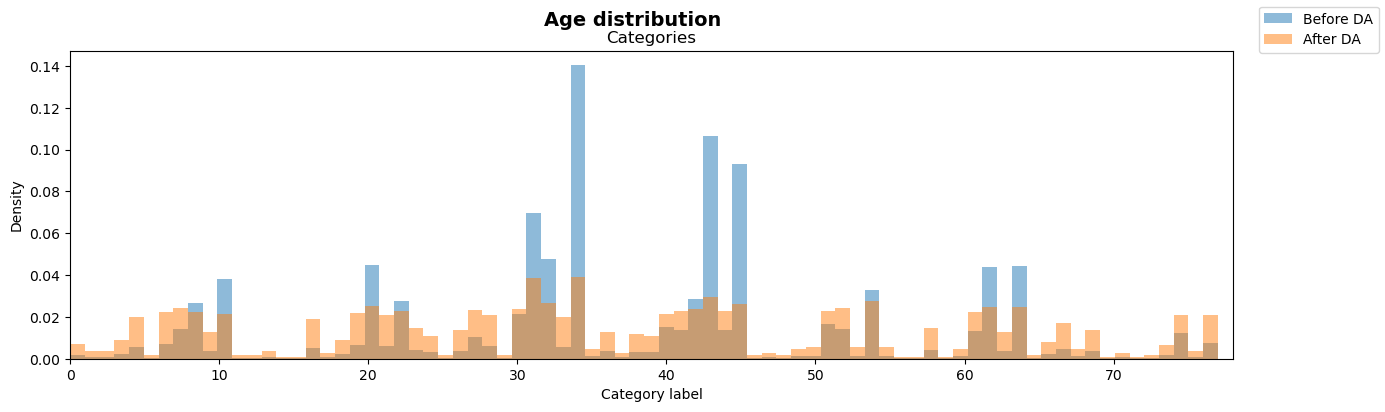

Before DA there were 4065 samples. After DA there are 14571 samples.


In [ ]:
_REDO_DA: bool = True  # True # False

try:
    if _REDO_DA:
        raise FileNotFoundError("Re-doing the DA again")
        
    X_train_augmented = np.load(f'{_OUTPUT_PATH}/data_train_augmented.npy')
    M_train_augmented = np.load(f'{_OUTPUT_PATH}/meta_data_train_augmented.npy')
    Y_train_augmented = np.load(f'{_OUTPUT_PATH}/labels_train_augmented.npy')
    C_train_augmented = np.load(f'{_OUTPUT_PATH}/categories_train_augmented.npy')
    
    comp_categories = create_compound_categories(Y_train, M_train)
    da_comp_categories = list(C_train_augmented)
    
    # print info
    print(f"Before DA there were {len(comp_categories)} samples. "
          f"After DA there are {len(da_comp_categories)} samples.")
    
    # print distr
    _show_distribution([comp_categories, da_comp_categories], ['Before DA', 'After DA'])
    
except FileNotFoundError:
    
    augmented_arrays: dict = advanced_da(_silent=False)
    X_train_augmented: np.ndarray = augmented_arrays['samples']
    C_train_augmented: np.ndarray = augmented_arrays['categories']
    M_train_augmented: np.ndarray = augmented_arrays['metadata']
    Y_train_augmented: np.ndarray = augmented_arrays['labels']

    np.save(f'{_OUTPUT_PATH}/data_train_augmented', X_train_augmented)
    np.save(f'{_OUTPUT_PATH}/categories_train_augmented', C_train_augmented)
    np.save(f'{_OUTPUT_PATH}/meta_data_train_augmented', M_train_augmented)
    np.save(f'{_OUTPUT_PATH}/labels_train_augmented', Y_train_augmented)

### Visualization of some samples

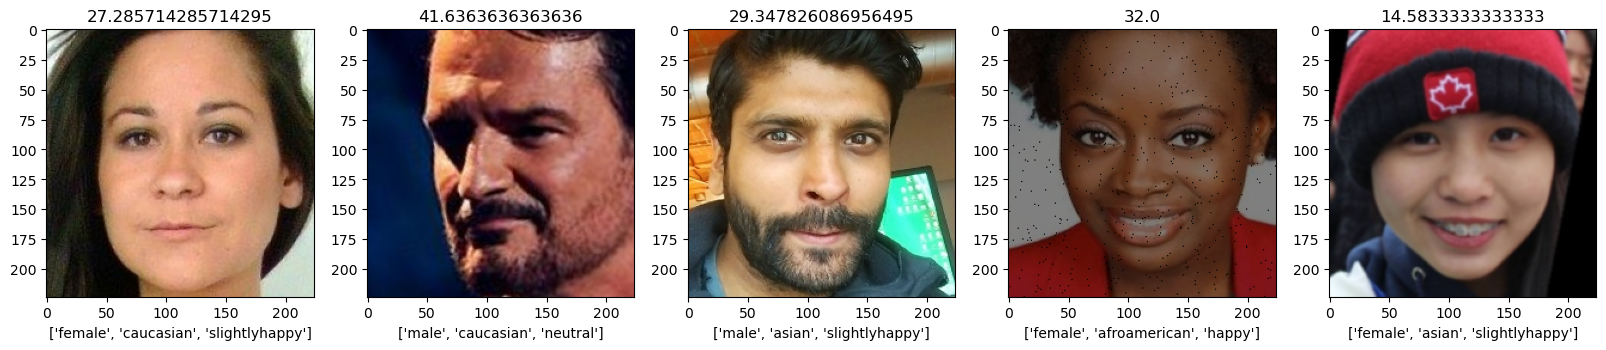

In [ ]:
import random
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train_augmented))
    ax.imshow(cv2.cvtColor(X_train_augmented[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train_augmented[idx] * 100)
    ax.set(xlabel=[M_train_augmented[idx][0],M_train_augmented[idx][1],M_train_augmented[idx][2]])

## Histograms visualization

### Before DA

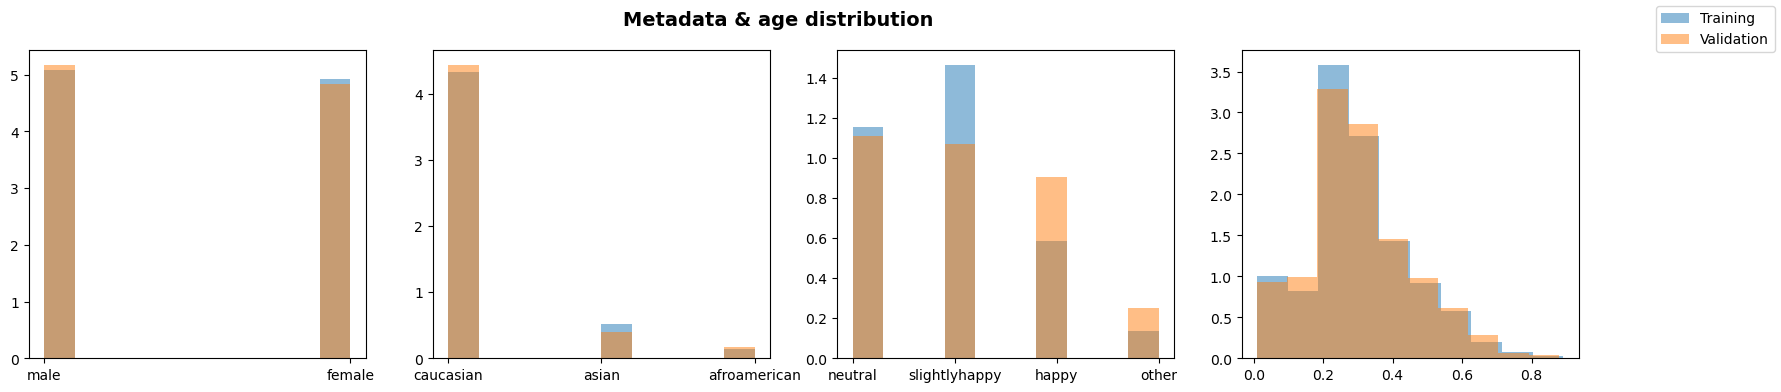

In [ ]:
_show_all_four_distributions(M_train, M_valid, Y_train, Y_valid)

## After DA 

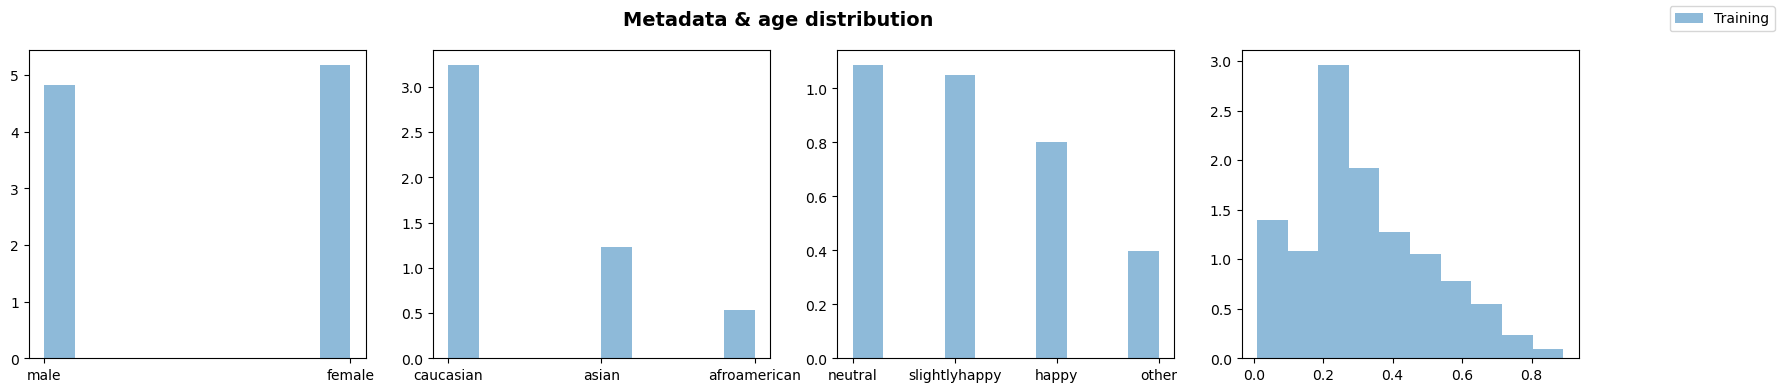

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle('Metadata & age distribution', fontsize=14, fontweight='bold')
labels = ['Training']

for _i_label, metadata_array in enumerate([M_train_augmented]):
    gender = []
    etnhicity = []
    emotion = []

    for _sample in metadata_array:
        gender.append(_sample[0])
        etnhicity.append(_sample[1])
        emotion.append(_sample[2])

    ax1.hist(gender, density=True, label=labels[_i_label], alpha=0.5)
    ax2.hist(etnhicity, density=True, label=labels[_i_label], alpha=0.5)
    ax3.hist(emotion, density=True, label=labels[_i_label], alpha=0.5)
    ax4.hist(Y_train_augmented, density=True, label=labels[_i_label], alpha=0.5)

fig.legend(labels)
plt.savefig(f'{_OUTPUT_PATH}/train_val_histograms_after_da.png', dpi=150)
plt.show()

## We select the backbone of the net

In [ ]:
BACKBONE: str = 'VGG19'  # 'ResNet50'  # 'VGG19'
assert BACKBONE in ('VGG19', 'ResNet50'), "Unrecognized backbone choice."

In [ ]:
# INPUT PREPROCESSING: needed for ResNet-50 or VGG19
_input_preprocess: callable = tf.keras.applications.resnet50.preprocess_input if BACKBONE == 'ResNet50' else tf.keras.applications.vgg19.preprocess_input

X_train = X_train_augmented
M_train = M_train_augmented
Y_train = Y_train_augmented

# train
for i in range(0,X_train.shape[0]):
    x = X_train[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_train[i,] = _input_preprocess(x)

# validation
for i in range(0,X_valid.shape[0]):
    x = X_valid[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_valid[i,] = _input_preprocess(x)  

# test
for i in range(0,X_test.shape[0]):
    x = X_test[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_test[i,] = _input_preprocess(x)

# Training strategy

## We use the 2-stage training strategy: in the 1st one just the FC layers are trained, in the 2nd one the whole model is trained

#### We can deactivate the 1st training stage or activate it (the latter is useful if the backbone is desired to be changed)

In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST1_AUGMENTATION = False  # False  # True
_EPOCHS_1ST_STAGE: int = 50  # 50
# if False, then the 1st stage training is also carried out 
#--------------------------

if LOAD_BEST_MODEL_ST1_AUGMENTATION:
    pass  # nothing is done, the trained model is already saved
else:
    # WE DOWNLOAD THE RESNET50
    if BACKBONE == 'ResNet50':
        if not os.path.isfile(f'{_OUTPUT_PATH}/model/weights.h5'):
            # downloading the data
            !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

            # decompressing the data
            with ZipFile(f'{_OUTPUT_PATH}/model.zip','r') as _zip:
                _zip.extractall()
                print('Model decompressed successfully')

            # removing the .zip file after extraction  to clean space
            !rm model.zip

        # we load the pretrained model, add some layers & train the last FC layers
        # then the model is saved as best_model.h5
        model = tf.keras.models.load_model(f'{_OUTPUT_PATH}/model/weights.h5')
    else:
        model = tf.keras.applications.VGG19()
        
        # Using the FC layer before the 'classifier_low_dim' layer as feature vector
        if BACKBONE == 'ResNet50':
            fc_512 = model.get_layer('dim_proj').output
        else:
            fc_512 = model.get_layer('fc2').output

        if BACKBONE == 'VGG19':
            # we freeze the layers here
            for layers in model.layers:
                layers.trainable = False

        # adding a dropout layer to minimize overfiting problems
        dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)
        # adding a few hidden FC layers to learn hidden representations
        fc_128 = tf.keras.layers.Dense(128, activation='relu', name='f_128')(fc_512)
        fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)

        # Includint an additional FC layer with sigmoid activation, used to regress
        # the apparent age
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

        # building the final model
        if BACKBONE == 'ResNet50':
            model = tf.keras.models.Model(inputs=model.get_layer('base_input').output,outputs=output)
        else:
            model = tf.keras.models.Model(inputs=model.layers[0].output,outputs=output)

        if BACKBONE == 'ResNet50':
            # we freeze the first layers (belonging to the Resnet)
            counter = 0
            for layer in model.layers:
                if counter <= 174: 
                    layer.trainable = False
                else:
                    layer.trainable = True
                counter +=1

        # defining the early stop criteria
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        # saving the best model based on val_loss
        mc = tf.keras.callbacks.ModelCheckpoint(f'{_OUTPUT_PATH}/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

        # defining the optimizer
        model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

        # training the model
        history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=_EPOCHS_1ST_STAGE, shuffle=True, verbose=1, callbacks=[es,mc])

        # saving training history (for future visualization)
        with open(f'{_OUTPUT_PATH}/train_history_1st_stage.pkl', 'wb') as handle:
            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

574726144/574710816 [==============================] - 4s 0us/step
Epoch 1/50
456/456 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.1339

### We can visualize the training history of the 1st stage

In [ ]:
train_hist_1st = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist_1st['loss'])
ax1.plot(train_hist_1st['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist_1st['mae'])
ax2.plot(train_hist_1st['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.savefig(f'{_OUTPUT_PATH}/train_history_aug_1st_stage.png', dpi=150)

## Re-training the 2nd stage (``LOAD_BEST_MODEL_ST2_AUGMENTATION`` -> ``False``)

### We unfreeze all the layers so that the WHOLE model can be trained

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

#--------------------------
LOAD_BEST_MODEL_ST2_AUGMENTATION = False  # True
_EPOCHS: int = 50  # 75
#--------------------------

if LOAD_BEST_MODEL_ST2_AUGMENTATION == True:
    if not os.path.isfile(f"{_OUTPUT_PATH}/best_model_2nd_stage_augmentation.h5"):
        # downloading the trained model
        !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2_aug.zip
        # decompressing the data
        with ZipFile('best_model_st2_aug.zip','r') as _zip:
            _zip.extractall()
        print('Model decompressed successfully')
        # removing the .zip file after extraction  to clean space
        !rm best_model_st2_aug.zip
    
    saved_model_2nd_augm = tf.keras.models.load_model(f'{_OUTPUT_PATH}/best_model_2nd_stage_augmentation.h5')

else:
    # loading the saved model (best model learned at stage 1)
    saved_model = tf.keras.models.load_model(f'{_OUTPUT_PATH}/best_model.h5')
  
    # setting all layers to trainable
    saved_model.trainable = True

    # training all layers (2nd stage), given the model saved on stage 1
    _lr: float = 1e-5  # 5e-4
    saved_model.compile(tf.keras.optimizers.Adam(learning_rate=_lr),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

    # defining the early stop criteria
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    # saving the best model (2nd stage) based on val_loss with a different name
    mc = tf.keras.callbacks.ModelCheckpoint(f'{_OUTPUT_PATH}/best_model_2nd_stage_augmentation.h5', monitor='val_loss', mode='min', save_best_only=True)
    # we set a learning rate scheduler to decrease it if the val_loss does not improve in 3 epochs
    # lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
    _callbacks = [es, mc] # , lr]
    
    history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=_EPOCHS, shuffle=True, verbose=1, callbacks=_callbacks)
    saved_model_2nd_augm = saved_model

## Visualizing the train history

In [ ]:
try:
    if LOAD_BEST_MODEL_ST2_AUGMENTATION == True:
        train_hist_2nd = pickle.load(open(f"{_OUTPUT_PATH}/train_history_2nd_stage.pkl","rb"))
    else:
        train_hist_2nd = history.history
        with open(f'{_OUTPUT_PATH}/train_history_2nd_stage.pkl', 'wb') as handle:
            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (Stage 2)', fontsize=14, fontweight='bold')

    ax1.plot(train_hist_2nd['loss'])
    ax1.plot(train_hist_2nd['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist_2nd['mae'])
    ax2.plot(train_hist_2nd['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

except ValueError as error:
    _msg: str = "There is an incompatibility problem with the pickle version used to serialize the train_history.pkl!"
    print(_msg)
    # raise ValueError(_msg) from error
    
    train_hist_2nd = history.history
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

    ax1.plot(train_hist_2nd['loss'])
    ax1.plot(train_hist_2nd['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist_2nd['mae'])
    ax2.plot(train_hist_2nd['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
plt.savefig(f'{_OUTPUT_PATH}/train_history_aug_better_training.png', dpi=150)

## Evaluating the MAE and biases in the validation set

In [ ]:
if not os.path.isfile(f'{_OUTPUT_PATH}/bias_functions.py'):
    !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/bias_functions.py
    print("\nBias functions downloaded\n")

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

#--------------------------
ENABLE_EVALUATION_ST2_AUGMENTED = True
#--------------------------

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
    # predict on the validation data
    predictions_st2_augmented = saved_model_2nd_augm.predict(X_valid, batch_size=32, verbose=1)
    # re-scaling the output predictions (from [0,1] to age range) using the
    # the normalization factor mentioned before
    predictions_st2_augmented_final = predictions_st2_augmented*100
    
    # evaluating on validation data
    error = []
    for i in range(0,len(Y_valid)):
        error.append(abs(np.subtract(predictions_st2_augmented_final[i][0],Y_valid[i]*100)))

    print('MAE (validation) = %.8f' %(np.mean(error)))
    
    # computing the age bias (model_stage_2)
    age_bias(predictions_st2_augmented_final,Y_valid*100)

    # computing the gender bias (model_stage_2)
    gender_bias(predictions_st2_augmented_final,Y_valid*100,M_valid)

    # computing the ethnicity bias (model_stage_2)
    ethnicity_bias(predictions_st2_augmented_final,Y_valid*100,M_valid)

    # computing the face bias (model_stage_2)
    face_expression_bias(predictions_st2_augmented_final,Y_valid*100,M_valid)
    


## Infering in the test set and saving the .zip

In [ ]:
import csv

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
    # making predictions on the TEST data
    predictions_st2_augmented_test = saved_model_2nd_augm.predict(X_test, batch_size=32, verbose=1)

    # re-scaling the predictions to the range of "ages" as the outputs are in the range of [0,1]
    predictions_st2_augmented_test_final = predictions_st2_augmented_test * 100

    # saving the predictions as a csv file
    with open(f'{_OUTPUT_PATH}/predictions.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(predictions_st2_augmented_test_final)
    csvFile.close()

    # compressing the csv file (to be submitted to codalab as prediction)
    ! zip predictions_custom_da_better_training.zip predictions.csv